# Разработка A/B-тестирования и анализ результатов

- Автор: Вермишян Валерий
- Дата: 23.07.2025

Цель проекта: провести A/B-тест рекомендательной системы развлекательного приложения.

# Цели и задачи проекта

**Цель** - провести A/B-тест рекомендательной системы развлекательного приложения.

**Задачи**:
- изучить данные
- рассчитать параметры теста
- оценить корректность его проведения
- проанализировать результаты эксперимента

# Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

# Содержимое проекта

1. Работа с историческими данными
2. Подготовка к тесту
3. Мониторинг А/В-теста
4. Проверка результатов A/B-теста

# 1. Работа с историческими данными

In [1]:
# импортируем все нужные нам библиотеки
import pandas as pd
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import scipy.stats as st
import matplotlib.pyplot as plt
from math import ceil
from statsmodels.stats.proportion import proportions_ztest

Изучим CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [2]:
sessions_history = pd.read_csv('sessions_project_history.csv')

sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


- Для каждого уникального пользователя `user_id` посчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [3]:
#проверим равенство общего кол-ва строк и кол-во уникальных значений session_id
if sessions_history.shape[0] == sessions_history['session_id'].nunique():
    print('Кол-во уникальных сессий пользователя = кол-ву строк с id этого пользователя')

Кол-во уникальных сессий пользователя = кол-ву строк с id этого пользователя


In [4]:
#посчитаем кол-во уникальных сессий для каждого пользователя и отсортируем по убыванию
users_sessions = sessions_history.groupby('user_id', 
                                          as_index=False)['session_id'].count().sort_values(by='session_id', 
                                                                                            ascending=False)

#выведем на экран все данные из таблицы sessions_history для пользователя с наибольшим кол-вом сессий
sessions_history[sessions_history['user_id'] == users_sessions.iloc[0,0]]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Видно, что порядок нумерации сессий совпадает с порядком дат

Проанализируем динамику регистраций. Изучим, как менялось число регистраций в приложении за время его существования.

In [5]:
# кол-во уникальных пользователей по дням
uniq_users = sessions_history.groupby('session_date')['user_id'].nunique()

# кол-во уникальных зарегистрированных пользователей по дням
uniq_reg_users = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique()

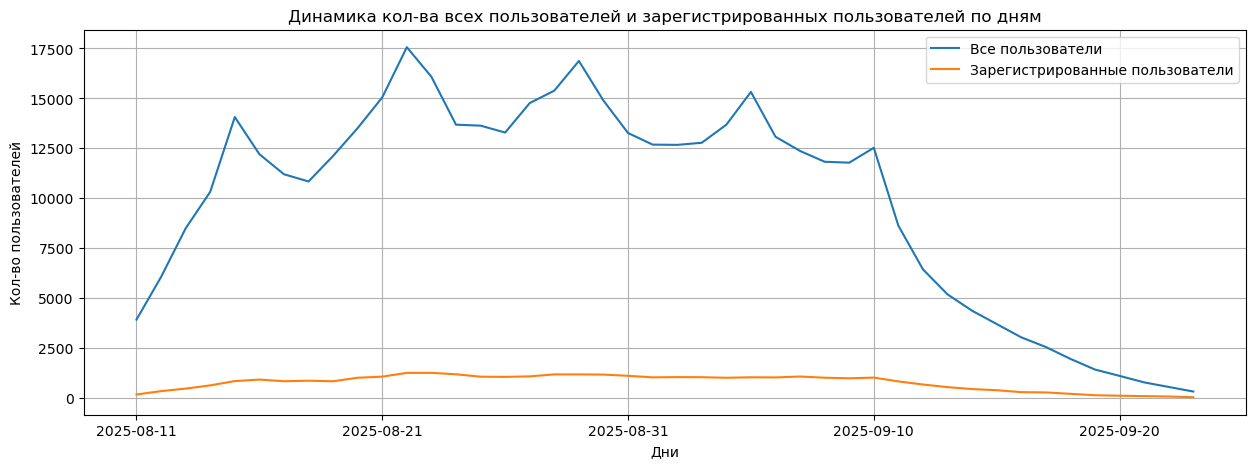

In [6]:
# строим график общего числа пользователей и общего числа зарегистрированных пользователей по дням
plt.figure(figsize=(15,5))

uniq_users.plot.line(label='Все пользователи')
uniq_reg_users.plot.line(label='Зарегистрированные пользователи')

plt.title('Динамика кол-ва всех пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дни')
plt.ylabel('Кол-во пользователей')
plt.legend()
plt.grid()
plt.show()

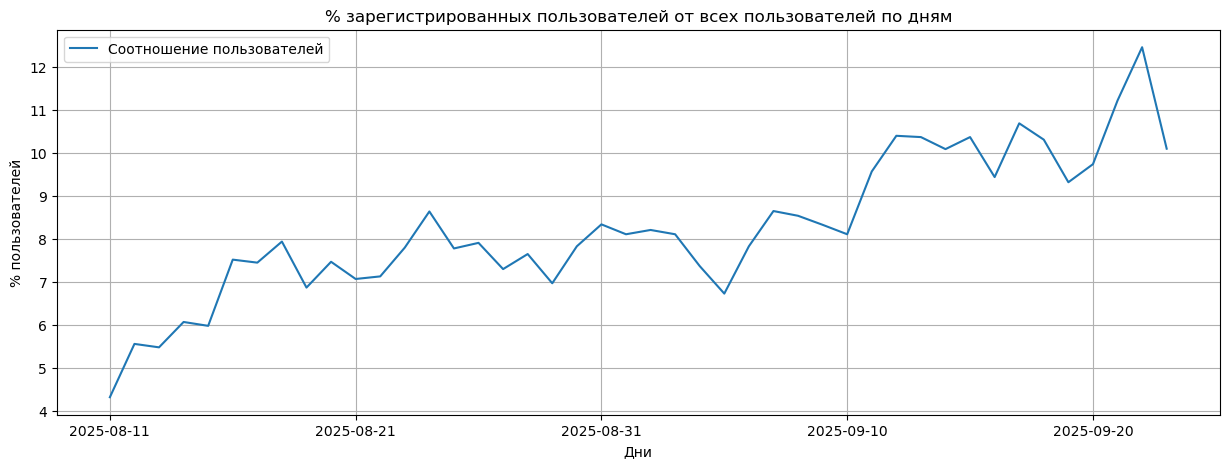

In [7]:
# строим график доли зарегистрированных пользователей от всех пользователей по дням
plt.figure(figsize=(15,5))

round(uniq_reg_users/uniq_users*100,2).plot.line(label='Соотношение пользователей')

plt.title('% зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('Дни')
plt.ylabel('% пользователей')
plt.legend()
plt.grid()
plt.show()

Видим, что % зарегистрированных пользователей с каждым днем больше

Проанализируем число просмотренных страниц

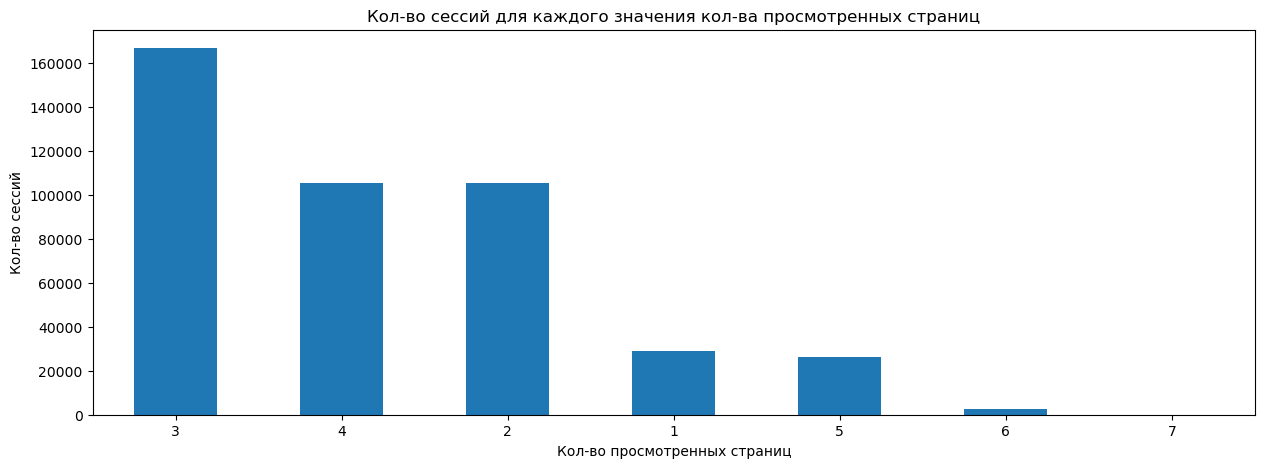

In [8]:
# группируем датафрейм по кол-ву просмотренных страниц
page_count = sessions_history.groupby('page_counter')['session_id'].count().sort_values(ascending=False)

# строим столбчатую диаграмму кол-ва просмотренных страниц
plt.figure(figsize=(15,5))

page_count.plot.bar()

plt.title('Кол-во сессий для каждого значения кол-ва просмотренных страниц')
plt.xlabel('Кол-во просмотренных страниц')
plt.ylabel('Кол-во сессий')
plt.xticks(rotation=0)
plt.show()

Изучим долю пользователей, просмотревших более четырёх страниц

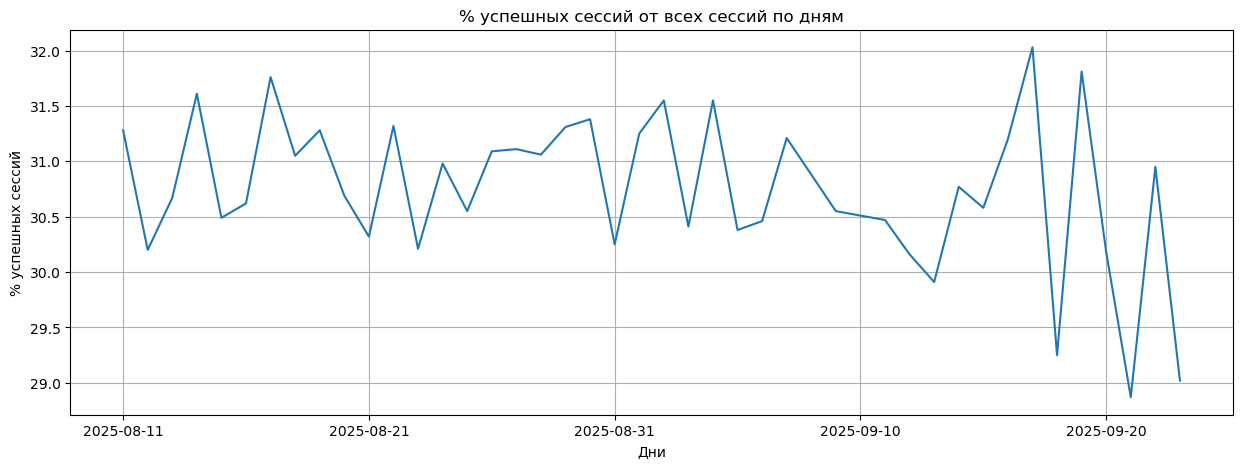

In [9]:
# создаем столбец good_session
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# считаем кол-во всех сессий и кол-во успешных по дням
sessions_total = sessions_history.groupby(['session_date'])['good_session'].agg(['count', 'sum'])

# строим график доли успешных сессий от всех сессий по дням
plt.figure(figsize=(15,5))

round(sessions_total.iloc[:,1]/sessions_total.iloc[:,0]*100,2).plot.line(label='Соотношение пользователей')

plt.title('% успешных сессий от всех сессий по дням')
plt.xlabel('Дни')
plt.ylabel('% успешных сессий')
plt.grid()
plt.show()

# 2. Подготовка к тесту

Формулировка нулевой и альтернативной гипотез

Будем работать с метрикой "Доля пользователей, просмотревших более четырёх страниц", так как она лучше всего отражает вовлеченность пользователей

- **Нулевая гипотеза** - значение метрики одинаково для каждой из групп
- **Альтернативная гипотеза** - значение метрики выше в тестовой группе

Рассчитаем размер выборки. Ориентируемся на следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста - 0.8

- MDE, — 3%.

In [10]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower для расчета размера выборки
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


Рассчитаем длительности A/B-теста

In [11]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = uniq_users.mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size*2)/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


# 3. Мониторинг А/В-теста

Проверим распределение пользователей за первые 3 дня теста

In [12]:
# создадим дф с данными за первые 3 дня теста
sessions_test_part = pd.read_csv('sessions_project_test_part.csv')

# группируем кол-во уникальных пользователей по тестовым группам
uniq_users = sessions_test_part.groupby('test_group', as_index=False)['user_id'].nunique()

# считаем процентную разницу в кол-ве пользователей
P = 100 * (abs(uniq_users.iloc[0,1] - uniq_users.iloc[1,1])/uniq_users.iloc[0,1])

print(f'Разница в кол-ве пользователей в двух группах составляет {round(P,1)}%')

Разница в кол-ве пользователей в двух группах составляет 0.7%


<Figure size 1500x500 with 0 Axes>

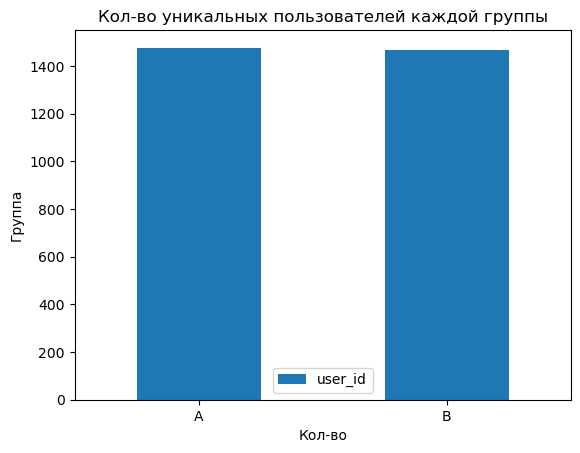

In [13]:
# строим столбчатую диаграмму кол-ва уникальных пользователей каждой группы
plt.figure(figsize=(15,5))

uniq_users.plot.bar(x='test_group', y='user_id')

plt.title('Кол-во уникальных пользователей каждой группы')
plt.xlabel('Кол-во')
plt.ylabel('Группа')
plt.xticks(rotation=0)
plt.show()

Проверим отсутствие пересечения пользователей

In [14]:
# разделим дф на группы
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

# получим серии пользователей по группам
group_a_users = group_a['user_id']
group_b_users = group_b['user_id']

if set(group_a_users) & set(group_b_users) == set():
    print('Пользователей, которые одновременно встречаются в группах A и B нет')
else:
    print('Есть пользователи, который одновременно встречаются в группах A и B')

Пользователей, которые одновременно встречаются в группах A и B нет


Проверим равномерность разделения пользователей по устройствам

In [15]:
# удалим дубли user_id
group_a_nod = group_a.drop_duplicates(subset='user_id', keep='first', inplace=False)
group_b_nod = group_b.drop_duplicates(subset='user_id', keep='first', inplace=False)

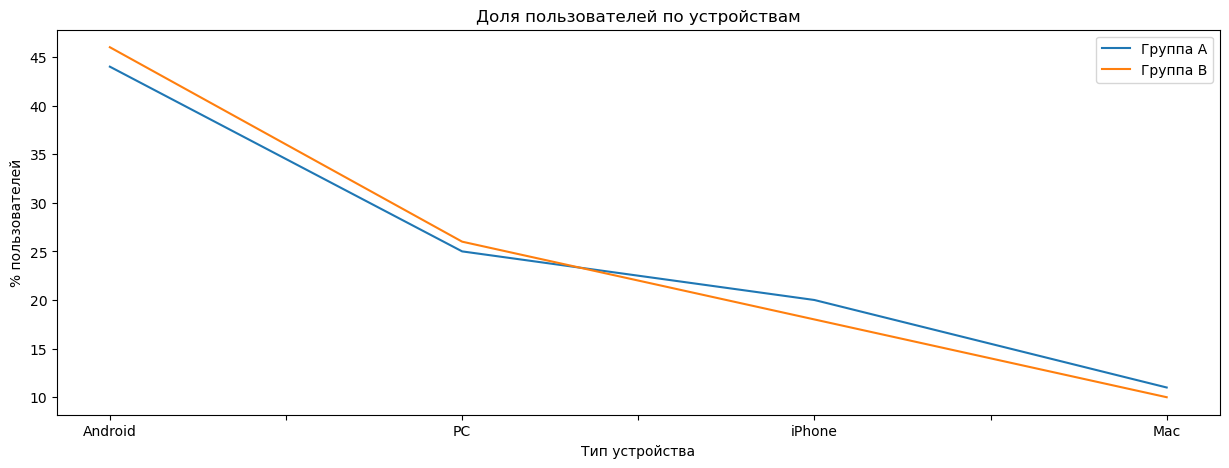

In [16]:
# получим доли каждого типа устройства для пользователей из групп
group_a_devises = round(group_a_nod['device'].value_counts(normalize=True)*100)
group_b_devises = round(group_b_nod['device'].value_counts(normalize=True)*100)

# построим график доли пользователей каждого устройства для каждой из групп

plt.figure(figsize=(15,5))

group_a_devises.plot.line(label='Группа A')
group_b_devises.plot.line(label='Группа B')

plt.title('Доля пользователей по устройствам')
plt.xlabel('Тип устройства')
plt.ylabel('% пользователей')
plt.legend()
plt.show()

Видно, что распределение одинаковое

Проверим равномерность разделения пользователей по регионам

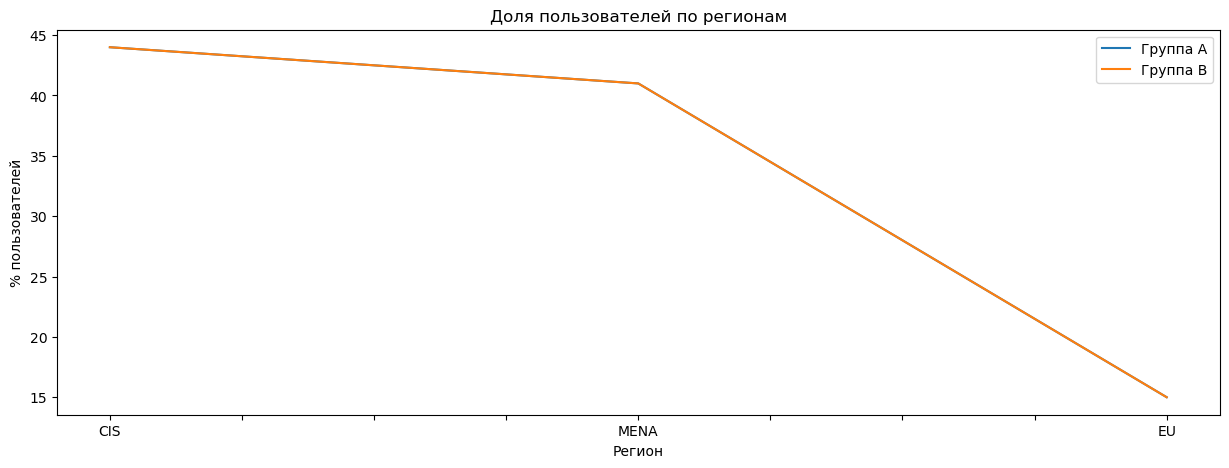

In [17]:
# получим доли каждого региона для пользователей из групп
group_a_regions = round(group_a_nod['region'].value_counts(normalize=True)*100)
group_b_regions = round(group_b_nod['region'].value_counts(normalize=True)*100)

# построим график доли пользователей каждого региона для каждой из групп

plt.figure(figsize=(15,5))

group_a_regions.plot.line(label='Группа A')
group_b_regions.plot.line(label='Группа B')

plt.title('Доля пользователей по регионам')
plt.xlabel('Регион')
plt.ylabel('% пользователей')
plt.legend()
plt.show()

Видно, что распределение одинаковое

Вывод после проверки A/B-теста

- Различие в кол-ве пользователей незначительно и составляет менее 1%
- Отсутствует пересечение пользователей в группах. Выборки независимы
- Сохраняется равномерное распределение пользователей по типам устройств и регионам

A/B-тест проходит корректно

# 4. Проверка результатов A/B-теста

Получение результатов теста и подсчёт основной метрики

In [18]:
# создадим дф с данными всего теста
sessions_test = pd.read_csv('sessions_project_test.csv')
# создаем столбец good_session
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

Проверка корректности результатов теста

In [19]:
# разделим дф на группы
group_A = sessions_test[sessions_test['test_group'] == 'A']
group_B = sessions_test[sessions_test['test_group'] == 'B']

# рассчитаем кол-во уникальных сессий для каждой группы по дням
uniq_sessions_group_a = group_A.groupby('session_date')['session_id'].nunique()
uniq_sessions_group_b = group_B.groupby('session_date')['session_id'].nunique()

In [20]:
# проведем статистический тест на равенство средних двух выборок
statistic, pvalue = st.ttest_ind(uniq_sessions_group_a, uniq_sessions_group_b, alternative='two-sided')

if pvalue > 0.05:
    print(f'pvalue составляет {round(pvalue,2)}, значит различие средних \
двух выборок не является статистически значимым. Группы сопоставимы')
else:
    print(f'pvalue составляет {round(pvalue,2)}, различие статистически значимы, значит группы не сопоставимы')


pvalue составляет 0.94, значит различие средних двух выборок не является статистически значимым. Группы сопоставимы


Сравним доли успешных сессий

In [21]:
# рассчитаем доли успешных сессий для каждой группы
group_A_good_session = round(group_A[group_A['good_session'] == 1].shape[0] / group_A.shape[0]*100,2)
group_B_good_session = round(group_B[group_B['good_session'] == 1].shape[0] / group_B.shape[0]*100,2)

print(f'Доля успешных сессий для группы A = {group_A_good_session}%')
print(f'Доля успешных сессий для группы B = {group_B_good_session}%')
print(f'Разница составляет {round(group_B_good_session-group_A_good_session,1)} процентных пункта или \
{round(abs(group_B_good_session-group_A_good_session)/group_B_good_session*100,1)}%')

Доля успешных сессий для группы A = 30.77%
Доля успешных сессий для группы B = 31.83%
Разница составляет 1.1 процентных пункта или 3.3%


Изучим, насколько статистически значимо изменение ключевой метрики

Процедем z-test пропорций

In [22]:
n_a = group_A.shape[0]

n_b = group_B.shape[0]

m_a = group_A[group_A['good_session'] == 1].shape[0]

m_b = group_B[group_B['good_session'] == 1].shape[0]

p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'pvalue={p_value_ztest}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

text_interpretation = 'увеличилась'

print(f'При переходе на новый алгоритм рекомендаций доля успешных сессий {text_interpretation}')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.00015747399880361237
Нулевая гипотеза не находит подтверждения!
При переходе на новый алгоритм рекомендаций доля успешных сессий увеличилась


**Вывод по результатам A/B-эксперимента**

Был проведен а/б-тест нового алгоритма рекомендаций.

Характеристики эксперимента:

- Эксперимент длился 20 дней. В группе А было задействовано 15 163 пользователй, в группе B 15 416. Всего 30 579 пользователей.
- В качестве целевой метрики была выбрана доля успешных сессий (отношение сессий с кол-вом просмотренных страниц >= 4 ко всем сессиям).
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.

По результатам а/б-теста можно сказать, что внедрение нового алгоритма положительно повлияло на % успешных сессий. Метрика выросла на 1.1 процентный пункт или на 3.3%

p-value для оценки статистической значимости выявленного эффекта = 0.0001574739988036123

Нововведение стоит внедрить в приложение